In [1]:
import torch
import numpy as np
import utils.duckdb as db
import pandas as pd
import utils.nn as nn
import copy
import os
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64 // 4, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

model = Net()
model.load_state_dict(torch.load('models/mnist_cnn.pt', weights_only=True))
model.eval()

db.reconnect()
db.con.execute(f"IMPORT DATABASE 'dbs/eval_cnn.db'")

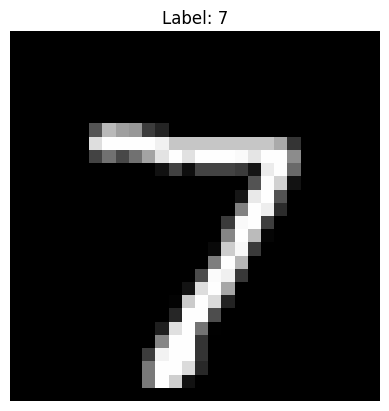

In [2]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

dataset = datasets.MNIST('../data', train=False)
image, label = dataset[0]

image = transforms.ToTensor()(image)
image_np = image.squeeze().numpy()

plt.imshow(image_np, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')  # Turn off axis
plt.show()

In [69]:
with open('queries/saliency.sql') as file:
    eval_faster_query = file.read()

with open('queries/saliency_faster.sql') as file:
    eval_query = file.read()

display(db.con.sql(eval_faster_query))
display(db.con.sql(eval_query))

┌──────────────┬───────────────────┬────────────────────────┐
│ input_set_id │ removed_neuron_id │        saliency        │
│    int32     │       int32       │         double         │
├──────────────┼───────────────────┼────────────────────────┤
│            0 │                 1 │    0.09289022867057094 │
│            0 │                 2 │    0.07934531481239798 │
│            0 │                 3 │ 0.00015843801909304345 │
│            0 │                 4 │  0.0001482533768199512 │
│            0 │                 5 │    0.11112653791483643 │
│            0 │                 6 │ 2.5480817298945135e-05 │
│            0 │                 7 │    0.09284612290702757 │
│            0 │                 8 │    0.09274012145037198 │
│            0 │                 9 │    0.11140223246863348 │
│            0 │                10 │    0.07988388716460812 │
│            · │                 · │             ·          │
│            · │                 · │             ·          │
│       

┌─────────────┬──────────────┬───────────┬────────────────────────┐
│ i_to_remove │ input_set_id │ output_id │        saliency        │
│    int32    │    int32     │   int32   │         double         │
├─────────────┼──────────────┼───────────┼────────────────────────┤
│           3 │            0 │     31769 │                    0.0 │
│           9 │            0 │     31768 │                    0.0 │
│          10 │            0 │     31766 │  6.030622687575385e-05 │
│          10 │            0 │     31765 │  8.339615819110552e-06 │
│          10 │            0 │     31763 │ 3.0576894915673725e-05 │
│           1 │            0 │     31763 │                    0.0 │
│           6 │            0 │     31762 │                    0.0 │
│           8 │            0 │     31769 │                    0.0 │
│          10 │            0 │     31767 │  0.0003332466583092393 │
│           7 │            0 │     31767 │                    0.0 │
│           · │            · │       ·   │      

In [71]:
import time

def load_image_into_input_table(image):
    db.con.execute("TRUNCATE input")
    for i, pixel in enumerate(image.flatten()):
        db.con.execute("""
            INSERT INTO input (input_set_id, input_node_idx, input_value)
            VALUES (0, $input_node_idx, $input_value)
        """,
        {'input_node_idx': i + 1, 'input_value': pixel.item()})
    db.con.sql("EXPORT DATABASE 'dbs/eval_cnn_w_input.db'")

load_image_into_input_table(image)

with open('queries/eval_recursive_from_input.sql') as file:
    original_query = file.read()

with open('queries/eval_recursive_from_input_optim.sql') as file:
    new_query = file.read()

timings = []
for i in range(0, 10):
    start = time.time()
    output = db.con.execute(original_query)
    end = time.time()
    timings.append(end - start)

print(f"Original query: {sum(timings) / len(timings)}")

timings = []
for i in range(0, 10):
    start = time.time()
    db.con.execute(new_query)
    end = time.time()
    timings.append(end - start)

print(f"Faster query: {sum(timings) / len(timings)}")

Original query: 0.22048795223236084
Faster query: 0.079925799369812
